# BitMEX Chat Analysis - November 2018
Authors : Arnaud Carrere & Oliver Yates

### Imports

In [1]:
#Data engineering
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import datetime

#Plot
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

#Sentiment analysis
from vader.vaderSentiment import SentimentIntensityAnalyzer as SIA

### Data loading

In [2]:
!ls "../Dumps"

BTC_USD_2018-11_CoinDesk.csv    bearish_tweets.csv
BitMEX_EnglishChat.csv          bitmex_chat_message_history.csv
BitMEX_channels.json            bullish_tweets.csv
BitMEX_chat.csv                 combined_tweets_Jul14-24.csv
BitMEX_chat_signals.csv         crypto_tweets_8_24_18.csv


In [3]:
data = pd.read_csv("../Dumps/BitMEX_EnglishChat.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633500 entries, 0 to 633499
Data columns (total 6 columns):
channelID    633500 non-null float64
date         633500 non-null object
fromBot      633500 non-null bool
id           633500 non-null int64
message      633500 non-null object
user         633500 non-null object
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 24.8+ MB


,channelID,date,fromBot,id,message,user
0,1.0,2018-11-30 23:59:58.612000+00:00,False,23727420,cherrydi: 3600,buop
1,1.0,2018-11-30 23:59:47.841000+00:00,False,23727417,rip vinny,bearaldorivera
2,1.0,2018-11-30 23:59:47.612000+00:00,False,23727416,3750 is fine wiht me,rektagainawman
3,1.0,2018-11-30 23:59:45.670000+00:00,False,23727414,CarlosM: savage,beandip
4,1.0,2018-11-30 23:59:39.036000+00:00,False,23727413,Shorters won't be happy until it goes to $1,cherrydi


### Data engineering

In [5]:
#Useless columns and NaN
columns_to_drop = ["channelID","id","fromBot"]
data.drop(columns_to_drop, axis=1, inplace=True)
data.fillna("", inplace=True)

#Date feature
data.date = pd.to_datetime(data.date)
data.index = pd.DatetimeIndex(data.date)

analyzer = SIA()
data["sentiment"] = data.apply(lambda row: analyzer.polarity_scores(row["message"])["compound"], axis=1)

data.head()

,date,message,user,sentiment
date,,,,
2018-11-30 23:59:58.612,2018-11-30 23:59:58.612,cherrydi: 3600,buop,0.0000
2018-11-30 23:59:47.841,2018-11-30 23:59:47.841,rip vinny,bearaldorivera,0.0000
2018-11-30 23:59:47.612,2018-11-30 23:59:47.612,3750 is fine wiht me,rektagainawman,0.2023
2018-11-30 23:59:45.670,2018-11-30 23:59:45.670,CarlosM: savage,beandip,-0.4588
2018-11-30 23:59:39.036,2018-11-30 23:59:39.036,Shorters won't be happy until it goes to $1,cherrydi,-0.4585


### Internal statistics

In [6]:
data = data[(data.date < datetime.datetime(2018,12,1)) & (data.date >= datetime.datetime(2018,11,1))]

start = data.date.min()
end = data.date.max()

print("BitMEX IRC chat analysis from {} to {}".format(str(start),str(end)))

BitMEX IRC chat analysis from 2018-11-01 00:00:00.419000 to 2018-11-30 23:59:58.612000


### Users

In [7]:
users = data["user"].unique()

print("{:.0f} users have been active on the chat\n".format(len(users)))

9512 users have been active on the chat



### Sentiment

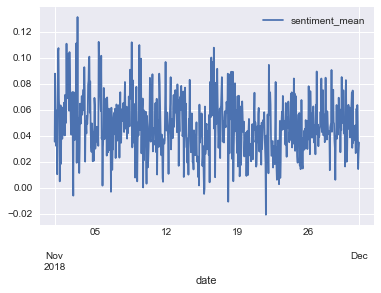

In [8]:
hourly = pd.DataFrame()
hourly['sentiment_mean'] = data.sentiment.resample('H').mean()
hourly.plot()

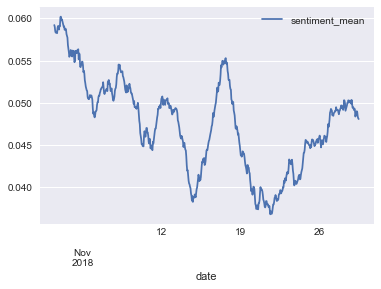

In [9]:
daily = hourly.rolling(72, center=True).mean()
daily = daily[daily.index <= datetime.datetime(2018,11,30,0,0)]
daily.plot()

### Plot both sentiment and BTC/USD price

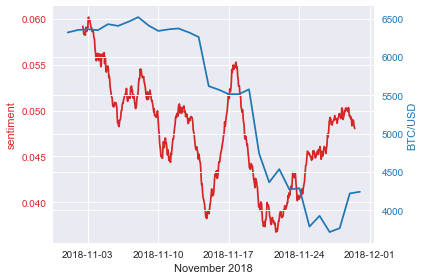

In [10]:
#Load BTC price
btc_price = pd.read_csv("../Dumps/BTC_USD_2018-11_CoinDesk.csv")
btc_price.rename(index=str, columns={"date_UTC": "date", "price_USD": "BTC/USD"}, inplace=True)
btc_price.index = pd.DatetimeIndex(pd.to_datetime(btc_price.date))
btc_price.drop(["currency","date"], axis=1, inplace=True)

#Convert timeseries from Dayly to Hourly
btc_price = btc_price["BTC/USD"].resample('H').interpolate(method='linear')

#Plot
t = btc_price.index
data1 = daily
data2 = btc_price

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('November 2018')
ax1.set_ylabel('sentiment', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC/USD', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()